In [1]:
import os
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import numpy as np
import cartopy.crs as ccrs
import seaborn as sns
from astropy.table import Table
from matplotlib.ticker import FuncFormatter

In [2]:
os.chdir('/home/walml/repos/zoobot')

In [3]:
# 'Fixed' classifications from *_fixes.ipynb
# dr2_c = pd.read_csv('dr2_aggregated_votes_all_subjects.csv')  # now also includes subject info, like DR5
dr2_c = pd.read_csv('dr2_aggregated_votes_good_subjects.csv')  # now also includes subject info, like DR5
assert not any(dr2_c['iauname'].duplicated())
# will get from NSA again anyway
del dr2_c['ra']
del dr2_c['dec']
del dr2_c['redshift']

dr5_c = pd.read_parquet('/home/walml/repos/zoobot/current_final_dr5_result_without_metadata.parquet')
assert not any(dr5_c['iauname'].duplicated())

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (93) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
len(dr2_c)

92960

In [5]:
dr5_c['upload_group'].value_counts()

active_baseline    192557
pre_active          50946
active_priority      6939
calibration          1594
targeted             1250
Name: upload_group, dtype: int64

### Merge DR1/2 subject catalog with iauname, ra, dec, from NSA.


In [6]:

# nsa = Table.read('/media/walml/beta/galaxy_zoo/decals/catalogs/raw/nsa_v1_0_0.fits')
nsa = Table.read('/media/walml/beta/galaxy_zoo/decals/catalogs/raw/nsa_v1_0_1.fits')

nsa = nsa[['RA', 'DEC', 'IAUNAME', 'PETRO_THETA', 'PETRO_TH50', 'PETRO_TH90', 'ELPETRO_ABSMAG', 'SERSIC_NMGY', 'Z']]

nsa['ELPETRO_ABSMAG_R'] = nsa['ELPETRO_ABSMAG'][:, 4]
nsa['SERSIC_NMGY_R'] = nsa['SERSIC_NMGY'][:, 4]
del nsa['ELPETRO_ABSMAG']
del nsa['SERSIC_NMGY']

nsa['REDSHIFT'] = nsa['Z']
del nsa['Z']

nsa = nsa.to_pandas()
for col in nsa.columns.values:
    nsa[col.lower()] = nsa[col]
    del nsa[col]

nsa['iauname'] = nsa['iauname'].str.decode('utf8')
assert not any(nsa['iauname'].duplicated())


In [7]:
nsa.columns

Index(['ra', 'dec', 'iauname', 'petro_theta', 'petro_th50', 'petro_th90',
       'elpetro_absmag_r', 'sersic_nmgy_r', 'redshift'],
      dtype='object')

In [8]:
nsa.head()

,ra,dec,iauname,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,sersic_nmgy_r,redshift
0,146.714215,-1.041280,J094651.40-010228.5,7.247893,3.464192,10.453795,-19.303656,1789.257202,0.021222
1,146.628585,-0.765162,J094630.85-004554.5,5.617822,2.326989,6.721991,-19.976496,229.840393,0.064656
2,146.631706,-0.988347,J094631.59-005917.7,4.769891,2.278736,5.177910,-18.431812,82.228149,0.052654
3,146.934129,-0.670405,J094744.18-004013.4,6.243227,2.655191,9.177605,-21.559162,277.761200,0.121270
4,146.963500,-0.544776,J094751.74-003242.0,8.891541,4.383704,10.253274,-19.100992,132.772156,0.055981


In [9]:
# metadata_cols = ['iauname', 'ra', 'dec', 'petrotheta', 'petroth50', 'petroth90', 'rnmgy_r', 'redshift']
dr2 = pd.merge(dr2_c, nsa, on='iauname', how='inner')
assert len(dr2) == len(dr2_c)  # all must match exactly once
assert not any(dr2['subject_id'].duplicated())
assert not any(dr2['iauname'].duplicated())

In [10]:
dr2.iloc[0][-10:]  # 

dr2_jpeg_filled           False
good_subject_image         True
ra                       158.66
dec                    -0.85268
petro_theta             5.98512
petro_th50              2.88914
petro_th90              6.54693
elpetro_absmag_r        -21.084
sersic_nmgy_r           520.811
redshift              0.0737827
Name: 0, dtype: object

In [11]:
dr2['active_learning_on'] = False
dr2['upload_group'] = 'pre_active'

In [12]:
dr2

,subject_id,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,how-rounded_completely,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,ra,dec,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,sersic_nmgy_r,redshift,active_learning_on,upload_group
0,55a7d7a27a726119cd00000b,19,15,5,16,2,1,2,13,2,...,158.659544,-0.852680,5.985117,2.889140,6.546928,-21.083954,520.810913,0.073783,False,pre_active
1,55a7d7a27a726119cd00000c,31,2,3,27,4,0,1,1,1,...,158.928432,-0.752741,3.493677,1.599772,4.897500,-20.905863,157.557159,0.115605,False,pre_active
2,55a7d7a27a726119cd00000d,33,1,7,21,12,0,0,1,0,...,158.757099,-0.831234,2.698255,1.326934,3.000635,-19.841774,58.042347,0.118851,False,pre_active
3,55a7d7a27a726119cd00000e,31,14,4,15,16,0,0,14,0,...,159.207820,-0.631470,6.951218,3.622341,7.018666,-19.598785,173.327042,0.063560,False,pre_active
4,55a7d7a27a726119cd00000f,40,6,5,10,29,1,0,6,0,...,159.196722,-0.682358,4.589167,2.078999,5.593759,-20.028103,106.315079,0.095834,False,pre_active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92955,56f3deb65925d90042037015,6,12,10,4,1,1,0,12,0,...,217.692900,-1.673523,10.527441,5.647549,11.515634,-18.833578,104.730103,0.055447,False,pre_active
92956,56f3deb65925d90042037017,21,15,4,17,4,0,0,15,0,...,217.054418,-1.929178,6.721991,3.366963,9.033441,-18.913054,109.902344,0.054090,False,pre_active
92957,56f3deb65925d90042037019,22,15,2,2,16,4,11,4,11,...,216.944227,-1.432235,5.407866,2.608586,8.073513,-21.807213,236.407684,0.138307,False,pre_active
92958,56f3deb65925d9004203701b,30,2,3,26,3,1,0,2,0,...,216.924991,-1.755687,15.874659,5.831343,21.499472,-21.364548,1709.476807,0.053837,False,pre_active


## Repeat the same process with DR5. Classifications already include some metadata, so no need for subject catalog.

In [13]:

metadata_cols = ['iauname', 'ra', 'dec', 'redshift', 'petro_theta', 'petro_th50', 'petro_th90', 'sersic_nmgy_r', 'elpetro_absmag_r']  # ra, dec, redshift already included
dr5 = pd.merge(dr5_c, nsa[metadata_cols], on='iauname', how='inner')
assert len(dr5) == len(dr5_c)

In [14]:
dr5['upload_group'].value_counts()

active_baseline    192557
pre_active          50946
active_priority      6939
calibration          1594
targeted             1250
Name: upload_group, dtype: int64

In [15]:
dr5['active_learning_on'] = dr5['upload_group'].isin(['active_random', 'active_priority'])

In [16]:
dr5

,iauname,bar_no,bar_strong,bar_weak,bulge-size_dominant,bulge-size_large,bulge-size_moderate,bulge-size_none,bulge-size_small,disk-edge-on_no,...,upload_group,ra,dec,redshift,petro_theta,petro_th50,petro_th90,sersic_nmgy_r,elpetro_absmag_r,active_learning_on
0,J112953.88-000427.4,13,2,1,1,6,9,0,0,16,...,pre_active,172.474526,-0.074281,0.124142,4.202472,1.835066,5.414066,167.262878,-21.253342,False
1,J104325.29+190335.0,2,0,0,1,0,1,0,0,2,...,targeted,160.856533,19.060441,0.049088,10.757237,4.405412,14.320828,2941.729248,-21.775410,False
2,J104629.54+115415.1,2,0,2,0,0,2,0,2,4,...,active_baseline,161.623135,11.904197,0.092906,9.726173,4.719870,13.139816,125.076324,-19.947397,False
3,J082950.68+125621.8,0,0,0,0,0,0,0,0,0,...,active_baseline,127.461190,12.939386,0.066619,6.528331,2.929065,7.224961,173.592026,-19.800629,False
4,J122056.00-015022.0,3,0,0,0,0,2,0,1,3,...,active_baseline,185.233342,-1.839340,0.070042,5.054409,2.521897,6.496888,88.826881,-19.013256,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253281,J144017.17+234347.3,0,0,0,0,0,0,0,0,0,...,active_baseline,220.071553,23.729825,0.135569,5.128151,2.160872,6.818261,125.146088,-21.286007,False
253282,J133751.46+253954.0,0,0,0,0,0,0,0,0,0,...,active_baseline,204.464417,25.665029,0.031913,4.545066,2.009910,5.407866,342.469788,-18.737637,False
253283,J130734.26+061155.7,0,0,0,0,0,0,0,0,0,...,active_baseline,196.892784,6.198813,0.137835,5.253455,2.213671,7.401498,221.358963,-21.575876,False
253284,J163830.70+315116.7,0,0,0,0,0,0,0,0,0,...,active_baseline,249.627951,31.854632,0.059837,37.860394,17.295427,43.632080,749.883667,-21.012257,False


## Work out which galaxies are shared

In [17]:
dr5['in_gzd_ab'] = dr5['iauname'].isin(dr2['iauname'])
dr2['in_gzd_c'] = dr2['iauname'].isin(dr5['iauname'])

In [18]:
dr5['in_gzd_ab'].value_counts()

False    220829
True      32457
Name: in_gzd_ab, dtype: int64

In [19]:
dr5.query('in_gzd_ab')['upload_group'].value_counts()

active_baseline    23214
pre_active          5350
active_priority     2082
calibration         1497
targeted             314
Name: upload_group, dtype: int64

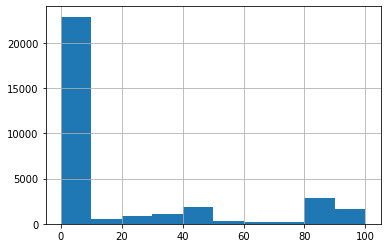

In [20]:
dr5.query('in_gzd_ab')['smooth-or-featured_total-votes'].hist(range=(0, 100))

In [21]:
dr2['in_gzd_c'].value_counts()

False    60503
True     32457
Name: in_gzd_c, dtype: int64

## Check the calibration galaxies are shared

1497 calibration is less than 1594 (DR5 'calibration' subjects with good images)- why not all calibration in DR2?



In [22]:
dr2_subjects = Table.read('/media/walml/beta/galaxy_zoo/decals/dr1_dr2/subjects/decals_dr1_and_dr2_with_subj_id.csv')[['dr8objid', 'iauname']].to_pandas()

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'dr8objid' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
dr2_subjects['iauname'].isin(dr5.query('upload_group == "calibration"')['iauname']).sum()  # includes 7k missed

1633

In [24]:
dr2_c['iauname'].isin(dr5.query('upload_group == "calibration"')['iauname']).sum()  # actually classified

1497

In [25]:
with open('dr1_subjects_never_classified.txt', 'r') as f:
    dr1_subjects_not_classified_not_repeat = set(f.readlines()[0].split('/n'))

In [26]:
dropped_calibration = set(dr5.query('upload_group == "calibration"')['iauname']) - set(dr2_c['iauname'])
len(dropped_calibration), len(dr1_subjects_not_classified_not_repeat)

(97, 7275)

In [27]:
dropped_calibration - dr1_subjects_not_classified_not_repeat


{'J074918.64+292635.6',
 'J080303.45+274438.3',
 'J100207.04+030327.6',
 'J112132.56+025314.1',
 'J142406.00+345335.0',
 'J215144.16+113431.5'}

Every dropped calibration subject (1601 -> 1503) is a galaxy in the DR1 lost set (i.e the 9k subjects not classified in DR1, - the 2k later classified in DR2).
So this is simply because I picked that 1601 assuming every DR1/2 subject was classified, which wasn't true.

Only the 1503 are actually useful calibration subjects. The dropped 91 were not classified in DR1/2. The 1497 drop is almost certainly retrospectively bad images in DR1/2. I have made sure the bar notebook counts galaxies starting from this 1497.

## Update upload groups accounting for selection effects

In [28]:
# using the "targeted vs random" notebook

In [29]:
with open('notebooks/catalogs/targeted_galaxies_would_include.json', 'r') as f:
    targeted_would_include_anyway = json.load(f)
dr5.loc[dr5['iauname'].isin(targeted_would_include_anyway), 'upload_group'] = 'pre_active'

In [30]:
with open('notebooks/catalogs/calibration_galaxies_would_include.json', 'r') as f:
    calibration_would_include_anyway = json.load(f)
dr5.loc[dr5['iauname'].isin(calibration_would_include_anyway), 'upload_group'] = 'pre_active'

In [31]:
dr5['upload_group'].value_counts()

active_baseline    192557
pre_active          51994
active_priority      6939
targeted             1145
calibration           651
Name: upload_group, dtype: int64

Why are the rest included in btoh? Must be a mistake I made. 
- Could leave in DR5 catalog, with column added flagging that they are also in DR2
- Could drop from DR5 (but this reduces the new answers)
- Could drop from DR2 (but this would make DR2 non-random, bad selection effects)

Probably best to flag that they are also in DR2 and leave it at that. Paper will need updating, in calibration selection effects section.

In [32]:
# active_baseline    23214
# pre_active          5350
# active_priority     2082
# calibration         1497
# targeted             314
# Name: upload_group, dtype: i

## Make plots of galaxies per DR

In [33]:
def custom_fmt(x, pos):
    if x == 0:
        return 0
    # in mpl, spaces take up half a character, so add 2 spaces per extra 0 to align labels
    if x == 5000:
        return '    5,000'  # extra space for lining up y axis
    if x == 50000:
        return '  50,000'
    if x == 10000:
        return '  10,000'
    if x == 100000:
        return '100,000'
    return x

In [34]:
comma_fmt = FuncFormatter(custom_fmt)

In [35]:
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c']

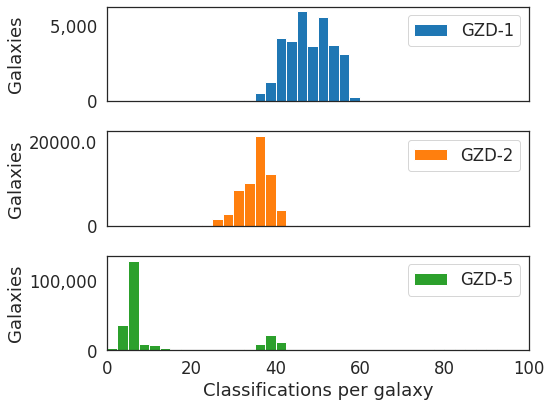

In [36]:
sns.set_context('notebook')
sns.set(font_scale=1.5)
sns.set_style('white')
_, bins = np.histogram(np.linspace(0, 100), bins=40)
fig, axes = plt.subplots(nrows=3, figsize=(8, 6), sharex=True)
axes[0].hist(dr2.query('data_release == "DR1"')['smooth-or-featured_total-votes'], bins=bins, color=color_cycle[0])
axes[0].legend(['GZD-1'])
axes[1].hist(dr2.query('data_release == "DR2"')['smooth-or-featured_total-votes'], bins=bins, color=color_cycle[1])
axes[1].legend(['GZD-2'])
axes[2].hist(dr5['smooth-or-featured_total-votes'], bins=bins, color=color_cycle[2])
axes[2].legend(['GZD-5'])
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_ylabel('Galaxies')
axes[2].set_xlabel('Classifications per galaxy')
axes[0].yaxis.set_major_formatter(comma_fmt)
axes[1].yaxis.set_major_formatter(comma_fmt)
axes[2].yaxis.set_major_formatter(comma_fmt)
fig.tight_layout()
fig.savefig('latest_totals_per_dr.png')
fig.savefig('latest_totals_per_dr.pdf')

In [37]:
(dr2['smooth-or-featured_total-votes'] > 30).sum()

86094

In [38]:
(dr2['smooth-or-featured_total-votes'] > 35).sum()

63007

In [39]:
(dr5['smooth-or-featured_total-votes'] > 35).sum()

54592

In [40]:
(dr5['smooth-or-featured_total-votes'] >= 3).mean(), (dr5['smooth-or-featured_total-votes'] >= 4).mean()

(0.9853722669235567, 0.9622482095338866)

(array([1.94353e+05, 4.98300e+04, 8.02300e+03, 9.87000e+02, 6.00000e+01,
        4.00000e+00, 8.00000e+00, 2.00000e+00, 1.50000e+01, 4.00000e+00]),
 array([  1. ,  31.2,  61.4,  91.6, 121.8, 152. , 182.2, 212.4, 242.6,
        272.8, 303. ]),
 <a list of 10 Patch objects>)

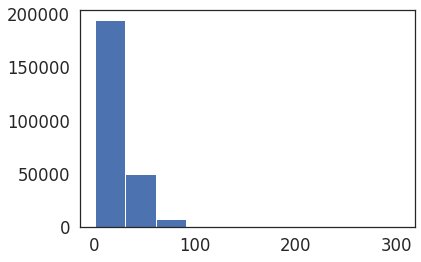

In [41]:
plt.hist(dr5['smooth-or-featured_total-votes'])

In [42]:
def get_png_loc(iauname): # relative
    return f'png_native/dr5/{iauname[:4]}/{iauname}.png'

In [43]:
dr5['png_loc'] = dr5['iauname'].apply(get_png_loc)
dr5['local_png_loc'] = dr5['png_loc'].apply(lambda x: os.path.join('/media/walml/beta/decals', x))

In [44]:
dr5['png_exists'] = dr5['local_png_loc'].apply(os.path.isfile)

In [45]:
dr5['png_exists'].mean()

1.0

In [46]:
assert all(dr5['png_exists'])

In [50]:
len(dr2), len(dr5)

(92960, 253286)

In [49]:
# dr2.to_csv('current_final_dr2_result.csv', index=False)
dr2.to_parquet('current_final_dr2_result.parquet', index=False)
# Final number: 92,960 galaxies

In [48]:
# dr5.to_csv('current_final_dr5_result.csv', index=False)
dr5.to_parquet('current_final_dr5_result.parquet', index=False)
# Final number: 253,286 galaxies